# SARSA
- online learning
- model free
- policy on
- predict $Q_\pi$ ($\pi$ = action policy)


# Q-learning
- online learning
- model free
- policy off
- predict $Q^*$

どちらもTD法をQ関数に拡張したものと捉えられる。

In [119]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from functions import get_s_next, possible_a, soft_max_policy, get_a, epsilon_greedy, fix_policy, make_subplot, pi_d

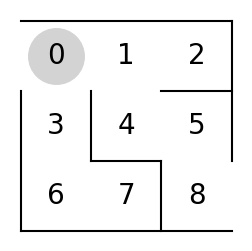

In [120]:
#迷路作成
fig = plt.figure(figsize=(3,3))

#壁
plt.plot([0, 3], [3, 3], color="k")
plt.plot([0, 3], [0, 0], color="k")
plt.plot([0, 0], [0, 2], color="k")
plt.plot([3, 3], [1, 3], color="k")
plt.plot([1, 1], [1, 2], color="k")
plt.plot([2, 3], [2, 2], color="k")
plt.plot([2, 1], [1, 1], color="k")
plt.plot([2, 2], [0, 1], color="k")

#数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha="center", va="center")

#円
circle, = plt.plot([0.5], [2.5], marker="o", color="#d3d3d3", markersize="40")

#メモリと枠の非表示
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", right="off", left="off", labelleft="off")
plt.box("off")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



In [121]:
#報酬関数g
g = np.zeros((9,4))
g[8,1] = 1 

In [122]:
# ランダム方策の準備
#パラメータθの初期化 
theta_0 = np.array([  #上、右、下、左
    [np.nan, 1, 1, np.nan],      #0
    [np.nan, 1, 1, 1],           #1
    [np.nan, np.nan, np.nan, 1], #2
    [1, np.nan, 1, np.nan],      #3
    [1, 1, np.nan, np.nan],      #4
    [np.nan, np.nan, 1, 1],      #5
    [1, 1, np.nan, np.nan],      #6
    [np.nan, np.nan, np.nan, 1], #7
    [1, 1, np.nan, np.nan],      #8
])
pi_0 = soft_max_policy(theta=theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.5        0.5        0.         0.        ]]


In [123]:
class TD:
    def __init__(self, ganma, alpha) -> None:
        self.ganma = ganma
        self.alpha = alpha
    
    def sarsa(self, s, a, r, s_next, a_next,    Q, step):
        Q_next = Q.copy()
        delta = r + self.ganma * Q[s_next, a_next] - Q[s,a]
        Q_next[s,a] = Q[s,a] + self.alpha(step) * delta
        return Q_next, delta
    
    def Q_learning(self, s, a, r, s_next, Q, step):
        Q_next = Q.copy()
        delta = r + self.ganma * np.max(Q[s_next,:]) - Q[s,a]
        Q_next[s,a] = Q[s,a] + self.alpha(step) * delta
        return Q_next, delta

        
    
    def learning_by_SARSA(self, pi, epoch, stop_epsilon, eps=0.1):
        Q = np.zeros((9,4))
        # t = [[10]*4]*9
        # Q = np.array(t)
        delta_l = []
        time_l = []
        for episode in range(epoch):
            step = 1
            delta_tmp = []

            s = 0
            if pi == "soft_max_policy":
                    pi_table = fix_policy(soft_max_policy(Q)) # soft max policy
            else:
                pi_table = fix_policy(epsilon_greedy(Q, eps=eps)) # epsilon greedy
            a = get_a(s, pi_table)
            # while reach goal
            while(True):
                if [s,a] == [8,1]:
                    # not calcurate delta
                    Q[s,a] = Q[s,a] + self.alpha(episode) * g[s, a]
                    break
                s_next = get_s_next(s,a)
                if pi == "soft_max_policy":
                    pi_table = fix_policy(soft_max_policy(Q)) # soft max policy
                else:
                    pi_table = fix_policy(epsilon_greedy(Q, eps=eps)) # epsilon greedy
                a_next = get_a(s_next, pi_table)
                Q, delta = self.sarsa(s=s, a=a, r=g[s,a], s_next=s_next, a_next=a_next, Q=Q, step=step)
                delta_tmp.append(delta)
                s = s_next
                a = a_next
                step += 1
                # 特別な処理
                if step > 1000:
                    break
                
            time_l.append(step)
            delta_l.append(np.array(delta_tmp).mean())
            
        return Q, delta_l, time_l
    
    def learning_by_Q(self, pi, epoch, stop_epsilon, eps=0.1):
        Q = np.zeros((9,4))
        #t = [[10]*4]*9
        # Q = np.array(t)
        delta_l = []
        time_l = []
        for episode in range(epoch):
            step = 1
            delta_tmp = []

            s = 0
            # while reach goal
            while(True):
                if pi == "soft_max_policy":
                    pi_table = fix_policy(soft_max_policy(Q)) # soft max policy
                else:
                    pi_table = fix_policy(epsilon_greedy(Q, eps=eps)) # epsilon greedy
                a = get_a(s, pi_table)
                s_next = get_s_next(s,a)
                if [s,a] == [8,1]:
                    # not calcurate delta
                    Q[s,a] = Q[s,a] + self.alpha(episode) * g[s, a]
                    break
                Q, delta = self.Q_learning(s=s, a=a, r=g[s,a], s_next=s_next, Q=Q, step=step)
                delta_tmp.append(delta)
                s = s_next
                step += 1
                # 特別な処理
                if step > 1000:
                    break
            time_l.append(step)
            delta_l.append(np.array(delta_tmp).mean())
            
        return Q, delta_l, time_l


In [124]:
#robbins monro
def alpha(step):
    return 1/ (step+1)

#default
def beta(**args):
    return 0.1

### epsilon greedy

s [1. 2. 3. 0. 1. 2. 0. 0. 1.]
q [1. 2. 3. 0. 1. 2. 0. 0. 1.]
answer 
[1, 2, 3, 0, 1, 2, 0, 3, 1]


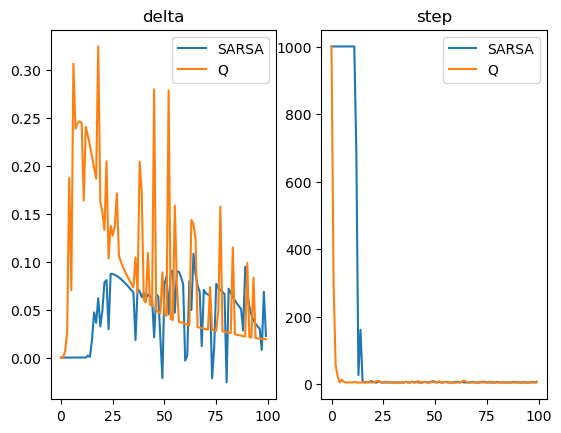

In [129]:
td = TD(ganma=0.7, alpha=alpha)
Q_sa, delta_sa, time_sa = td.learning_by_SARSA(pi="epsilon_greedy", epoch=100, stop_epsilon=10e-3)
Q_q, delta_q, time_q = td.learning_by_Q(pi="epsilon_greedy", epoch=100, stop_epsilon=10e-3)

pi_sa = pi_d(Q_sa)
pi_q = pi_d(Q_q)
print("s",pi_sa)
print("q", pi_q)
print(f"answer \n[1, 2, 3, 0, 1, 2, 0, 3, 1]")

graph = plt.figure()
make_subplot(graph=graph, place=[1, 2, 1], title="delta", v=[delta_sa, delta_q ], label_list=["SARSA", "Q"])
make_subplot(graph=graph, place=[1, 2, 2], title="step", v=[time_sa, time_q], label_list=["SARSA", "Q"])
plt.show()


s [1. 2. 3. 0. 1. 2. 0. 0. 1.]
q [1. 2. 3. 0. 1. 2. 0. 0. 1.]
answer 
[1, 2, 3, 0, 1, 2, 0, 3, 1]


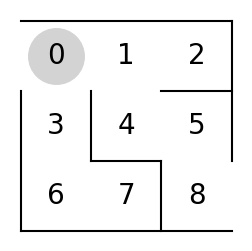

In [127]:
#迷路作成
fig = plt.figure(figsize=(3,3))

#壁
plt.plot([0, 3], [3, 3], color="k")
plt.plot([0, 3], [0, 0], color="k")
plt.plot([0, 0], [0, 2], color="k")
plt.plot([3, 3], [1, 3], color="k")
plt.plot([1, 1], [1, 2], color="k")
plt.plot([2, 3], [2, 2], color="k")
plt.plot([2, 1], [1, 1], color="k")
plt.plot([2, 2], [0, 1], color="k")

#数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha="center", va="center")

#円
circle, = plt.plot([0.5], [2.5], marker="o", color="#d3d3d3", markersize="40")

#メモリと枠の非表示
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", right="off", left="off", labelleft="off")
plt.box("off")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



### softmax policy

s [1. 2. 3. 0. 1. 2. 0. 3. 1.]
q [1. 2. 3. 0. 1. 2. 0. 3. 1.]
answer 
[1, 2, 3, 0, 1, 2, 0, 3, 1]


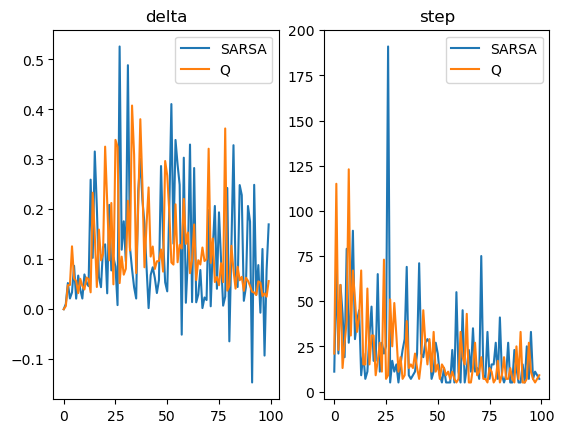

In [130]:
# softmaxの場合
td = TD(ganma=0.7, alpha=alpha)
Q_sa, delta_sa, time_sa = td.learning_by_SARSA(pi="soft_max_policy", epoch=100, stop_epsilon=10e-3)
Q_q, delta_q, time_q = td.learning_by_Q(pi="soft_max_policy", epoch=100, stop_epsilon=10e-3)

pi_sa = pi_d(Q_sa)
pi_q = pi_d(Q_q)
print("s",pi_sa)
print("q", pi_q)
print(f"answer \n[1, 2, 3, 0, 1, 2, 0, 3, 1]")

graph = plt.figure()
make_subplot(graph=graph, place=[1, 2, 1], title="delta", v=[delta_sa, delta_q ], label_list=["SARSA", "Q"])
make_subplot(graph=graph, place=[1, 2, 2], title="step", v=[time_sa, time_q], label_list=["SARSA", "Q"])
plt.show()


## summary

deltaについて  
- どの場合においても微妙　→ 最初の数ステップですでに収束しているからだと考えられる


stepについて  
- epsilon greedyの方が綺麗な収束をする